In [66]:
import nilearn
from nilearn.maskers import NiftiMasker
from nilearn.input_data import NiftiMasker
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
from nilearn.maskers import MultiNiftiMasker
from nilearn.datasets import fetch_miyawaki2008

dataset = fetch_miyawaki2008()
masker = MultiNiftiMasker(mask_img=dataset.mask, detrend=True,
                          standardize=True)
masker.fit()

# Loading the data from the csv files provided

visual_cortex = np.loadtxt('vc.csv')
v1 = np.loadtxt('v1.csv')
v4 = np.loadtxt('v4.csv')
stimuli = np.loadtxt('stimuli.csv')
conditions = pd.read_csv('conditions.csv', header=None).to_numpy().squeeze()


fmri_letters = visual_cortex[240:]
stimuli_letters = stimuli[240:]
fmri_shapes = visual_cortex[:240]
stimuli_shapes = stimuli[:240]


# Part 1: Visual Encoding

##### Given the Stimuli, we try to predict the brain response in this section.

##### Encoding Model for Letters

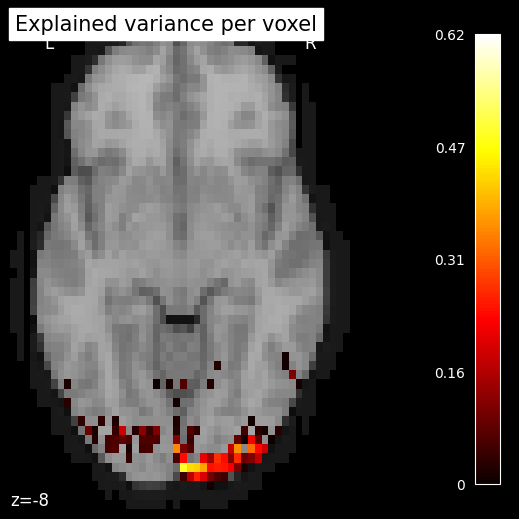

In [68]:
#We use the Ridge regression model and 10 fold cross validation

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

estimator = Ridge(alpha=100.)
cv = KFold(n_splits=10)

scores = []
for train, test in cv.split(X=stimuli_letters):
    predictions = Ridge(alpha=100.).fit(
    stimuli_letters.reshape(-1, 100)[train], fmri_letters[train]).predict(
        stimuli_letters.reshape(-1, 100)[test])
    scores.append(r2_score(fmri_letters[test], predictions,
                           multioutput='raw_values'))


from nilearn.image import threshold_img
from nilearn.plotting import plot_stat_map
from nilearn.plotting import find_xyz_cut_coords

cut_score = np.mean(scores, axis=0)
cut_score[cut_score < 0] = 0



score_map_img = masker.inverse_transform(cut_score)

thresholded_score_map_img = threshold_img(score_map_img, threshold=1e-6, copy=False)



display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel')


fig = plt.gcf()
fig.set_size_inches(5, 5)

[2612 2271 2600 2251]


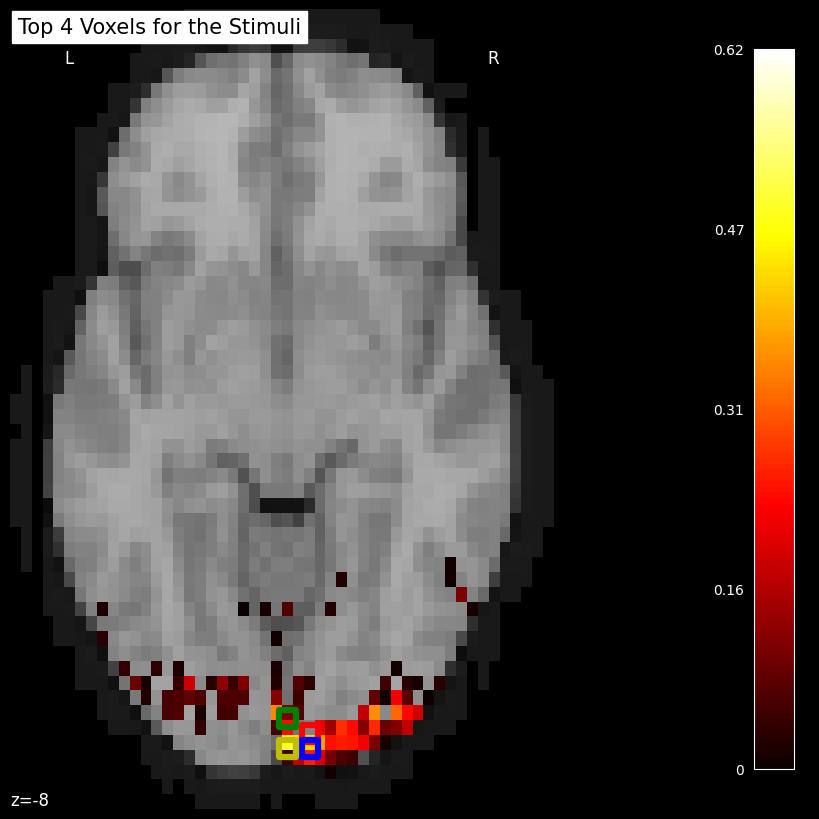

In [69]:
# Now we plot the top 4 voxels

top_four_indices = cut_score.argsort()[::-1][:4]
print(top_four_indices)

coords = []

for i in top_four_indices:
    masked_array = np.zeros(cut_score.shape)
    masked_array[i] = cut_score[i]
    masked_array_img = masker.inverse_transform(masked_array)
    coords.append(find_xyz_cut_coords(masked_array_img))

temp_coords = []
for coord in coords:
  temp_vec = coord[0:2]
  temp_vec.append(-8)
  temp_coords.append(temp_vec)

display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Top 4 Voxels for the Stimuli')

# creating and adding a marker for each voxel to the statistical map

for i, coordinate in enumerate(temp_coords):
    display.add_markers([coordinate], marker_color='none',
                        edgecolor=['r', 'g', 'b', 'y'][i],
                        marker_size=140, marker='s',
                        facecolor='none', lw=4.5)
    

fig = plt.gcf()
fig.set_size_inches(8, 8)

The plots above show the corresponding brain image for the stimuli(letters of the english alphabet in this case) shown to the subjects and the four most active voxels have been mapped in the second image. 

##### Encoding Model for Geometric Shapes

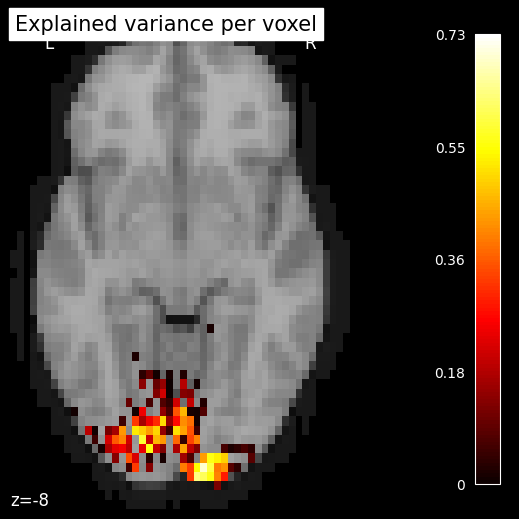

In [70]:
estimator = Ridge(alpha=100.)
cv = KFold(n_splits=10)

scores = []
for train, test in cv.split(X=stimuli_shapes):
    predictions = Ridge(alpha=100.).fit(
    stimuli_shapes.reshape(-1, 100)[train], fmri_shapes[train]).predict(
        stimuli_shapes.reshape(-1, 100)[test])
    
    scores.append(r2_score(fmri_shapes[test], predictions,
                           multioutput='raw_values'))
    
cut_score = np.mean(scores, axis=0)
cut_score[cut_score < 0] = 0

# We plot the fmri data for the shapes
score_map_img = masker.inverse_transform(cut_score)

thresholded_score_map_img = threshold_img(score_map_img, threshold=1e-6, copy=False)


display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel')


fig = plt.gcf()
fig.set_size_inches(5, 5)

[2438 2949 1553 2781]


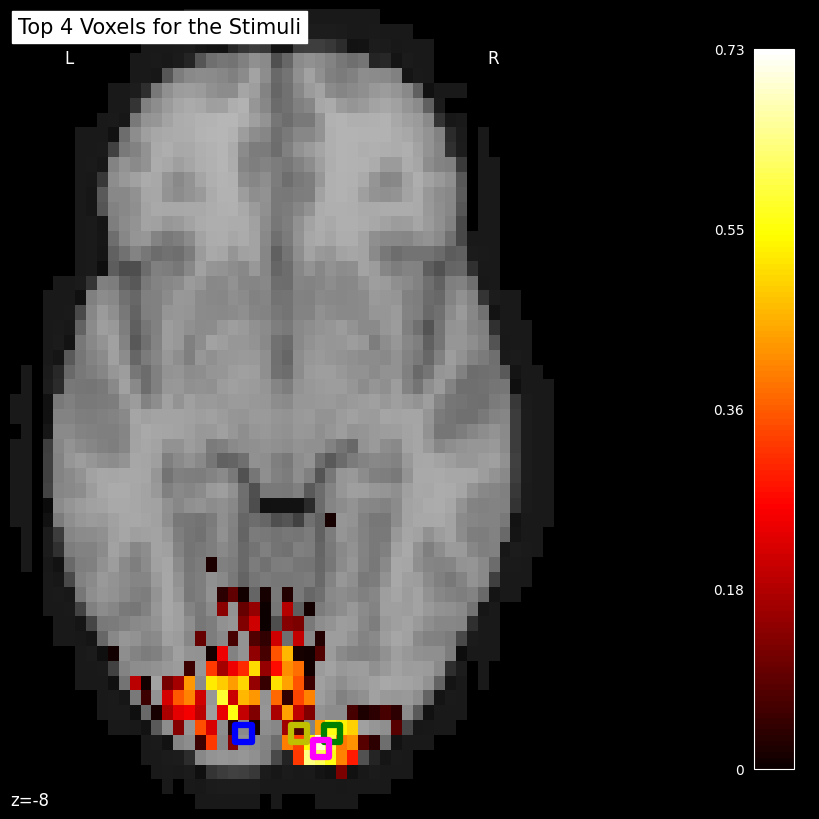

In [71]:
top_four_indices = cut_score.argsort()[::-1][:4]
print(top_four_indices)

coords = []

for i in top_four_indices:
    masked_array = np.zeros(cut_score.shape)
    masked_array[i] = cut_score[i]
    masked_array_img = masker.inverse_transform(masked_array)
    coords.append(find_xyz_cut_coords(masked_array_img))


temp_coords = []
for coord in coords:
  temp_vec = coord[0:2]
  temp_vec.append(-8)
  temp_coords.append(temp_vec)



display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Top 4 Voxels for the Stimuli')


for i, coordinate in enumerate(temp_coords):
    display.add_markers([coordinate], marker_color='none',
                        edgecolor=['y', 'g','b', 'magenta'][i],
                        marker_size=140, marker='s',
                        facecolor='none', lw=4.5)
    

fig = plt.gcf()
fig.set_size_inches(8, 8)

The code above explores the top 𝑅2-squared scores in brain voxels and its correspondence in the brain visual areas. As we can see from the statistical maps plotted above, the brain regions that get activated in response to the stimuli being a shape or an object is very different. The comparison between the two images show how the brain encoding works differently for different categories of stimulus. 

The brain regions in the visual cortex which are activated for the two categories of stimulus are pretty different. On viewing letters, the part of the brain that shows maximum response seems to be a lot more localised than the response when the geometrical shapes are shown, indicating towards a more distributed pattern of response in the latter case. The difference in response can also be observed across the two brain hemispheres. 

# Part 2: Representational Similarity Analysis

##### Constructing the Representational Dissimilarity Matrices (RDM) for Geometric Shapes and Alphabets for three masks: Visual Cortex, V1 and V4


##### Visual Cortex Mask

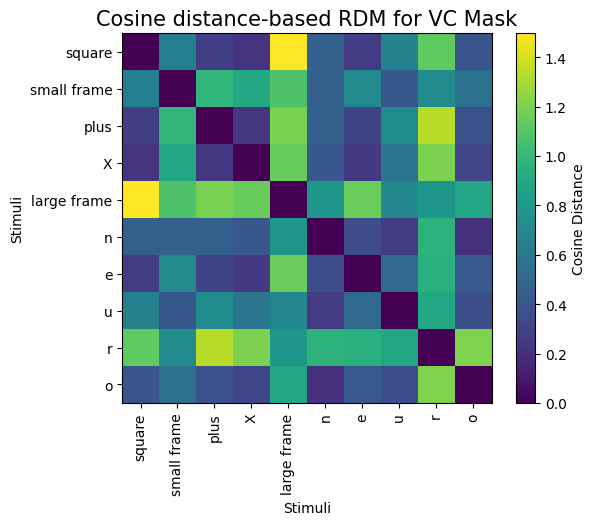

In [72]:
from collections import Counter
from sklearn.metrics import pairwise_distances

vc_mask_zip = list(zip(conditions, visual_cortex))
count = Counter(conditions)  # count the number of each condition


# Get a list of all the unique conditions

unique_cond=list(dict.fromkeys(conditions))

vc_avg=dict.fromkeys(unique_cond)
for key in vc_avg:
  vc_avg[key] = np.zeros(5438) # 5438 is the shape of data from VC file


# Averaging the data for each condition 
obj_sim_vc=[]
for row in vc_mask_zip:
  vc_avg[row[0]]+=row[1]

#preparing obj_sim for calculating the RDM

for key in vc_avg:
  vc_avg[key]/=count[key]
  obj_sim_vc.append(vc_avg[key])

# Finding the RDM for the objects
rdm_sim_vc=pairwise_distances(obj_sim_vc, metric='cosine')

# Plotting the RDM
plt.imshow(rdm_sim_vc)
plt.xlabel("Stimuli", fontsize=10)
plt.yticks(range(10), unique_cond)
plt.xticks(range(10), unique_cond, rotation='vertical')
plt.ylabel("Stimuli", fontsize=10)
plt.title("Cosine distance-based RDM for VC Mask", fontsize=15)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Cosine Distance', fontsize=10)
plt.show()


The plot above depicts the RDM, (the Representational Similarity Matrix (RSM), is just the matrix obtained by subratcting the values from 1, i.e. 1 - Dissimilarity = Similarity) which can be used to carry out Representational Similarity Analysis. We see that the diagonal has a value of 0 as the Dissimarity of a stimuli with itself would be 0. The Diagonal Devides the Matrix into two symmetrical halves, and looking at any one of them for analysis would suffice as they are mirror images of each other. 

We can clearly see patterns which would be similar having low dissimilarity scores(e.g. plus and cross, as they are very similiar to each other, mostly varying in the orientation) while objects which would be highly dissimilar (e.g. large frame and square) having high dissimilarity scores. If we look at the blocks of quadrant IV vs the blocks of quadrant III, we could draw some conclusions based on how similar the letters are to themselves as compared to other shapes. We see that on an average the blocks of quadrant IV are bluer, indicating the closeness of the letters within themselves as compared to the shapes as per the data given to us. This is in accordance with the statistical maps we plotted earlier where we saw that different brain regions correspond to the different stimuli category (shapes vs letters).

##### V1 Mask

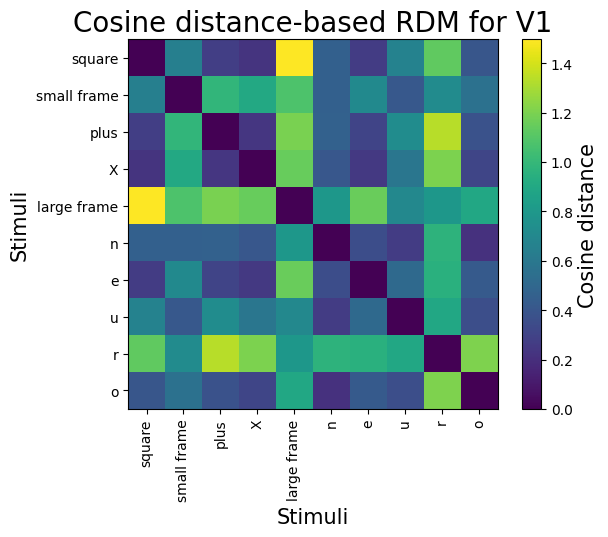

In [73]:
# Repeating the same for V1 mask

v1_mask_zip = list(zip(conditions, v1))
count = Counter(conditions)
unique_cond=list(dict.fromkeys(conditions))

v1_avg=dict.fromkeys(unique_cond)
for key in v1_avg:
  v1_avg[key] = np.zeros(5438) 

obj_sim_v1=[]
for row in vc_mask_zip:
  
  vc_avg[row[0]]+=row[1]
for key in vc_avg:
  vc_avg[key]/=count[key]
  obj_sim_v1.append(vc_avg[key])


rdm_sim_v1=pairwise_distances(obj_sim_v1, metric='cosine')

plt.imshow(rdm_sim_v1)
plt.xlabel("Stimuli", fontsize=15)
plt.yticks(range(10), unique_cond)
plt.xticks(range(10), unique_cond, rotation='vertical')
plt.ylabel("Stimuli", fontsize=15)
plt.title("Cosine distance-based RDM for V1", fontsize=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Cosine distance', fontsize=15)
plt.show()

##### V4 Mask

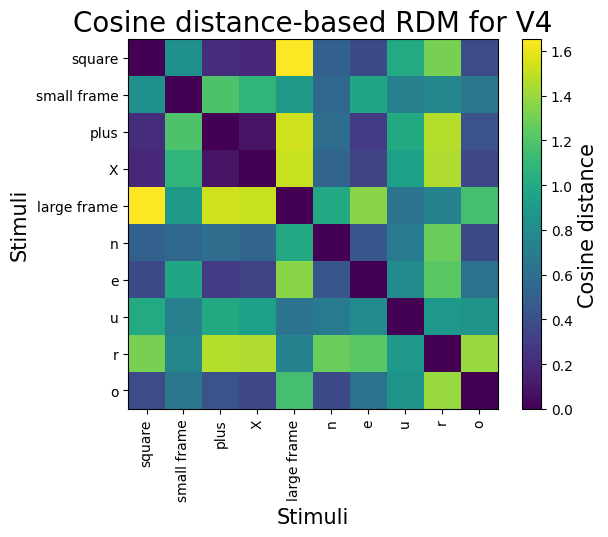

In [74]:
# Repeating the same for V4 mask

v4_mask_zip = list(zip(conditions, v4))
count = Counter(conditions)
unique_cond=list(dict.fromkeys(conditions))

v4_avg=dict.fromkeys(unique_cond)
for key in v4_avg:
  v4_avg[key] = np.zeros(557) # 557 is the shape of v4 

obj_sim_v4=[]
for row in v4_mask_zip:
  
  v4_avg[row[0]]+=row[1]
for key in vc_avg:
  v4_avg[key]/=count[key]
  obj_sim_v4.append(v4_avg[key])


rdm_sim_v4=pairwise_distances(obj_sim_v4, metric='cosine')

plt.imshow(rdm_sim_v4)
plt.xlabel("Stimuli", fontsize=15)
plt.yticks(range(10), unique_cond)
plt.xticks(range(10), unique_cond, rotation='vertical')
plt.ylabel("Stimuli", fontsize=15)
plt.title("Cosine distance-based RDM for V4", fontsize=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Cosine distance', fontsize=15)
plt.show()

The RDMs, as expected, look similar across all 3 masks. However, the RDMs for V1 and V2 masks are a bit more similar to each other as compared to the RDM generated using the VC mask, and on an average,  show a greater degree of dissimarity amongst the presented stimuli (the RDMs for V1 and V4 masks appear to have more yellowish tones). This is  probably because the VC incorporates information from a larger brain area as compared to V1, and V4, and hence, V1 and V4 show a higher dissimilarity on an average. 

# Part 3: Visual Decoding

##### Given the Brain fMRI data, we try to reconstruct the stimuli that was shown.

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import OrthogonalMatchingPursuit as OMP
from sklearn.metrics import accuracy_score


# Geometric figures
x_geo = visual_cortex[:240]
y_geo = stimuli[:240]

# Letters
x_let = visual_cortex[240:]
y_let = stimuli[240:]

# Preparing the variables neede to build the model: geometric figures
x_geo_train, x_geo_test, y_geo_train, y_geo_test = train_test_split(x_geo, y_geo, test_size=0.3)
x_geo_train = x_geo_train[y_geo_train[:, 0] != -1]
y_geo_train = y_geo_train[y_geo_train[:, 0] != -1]
x_geo_test = x_geo_test[y_geo_test[:, 0] != -1]
y_geo_test = y_geo_test[y_geo_test[:, 0] != -1]

# Preparing the variables neede to build the model: letters
x_let_train, x_let_test, y_let_train, y_let_test = train_test_split(x_let, y_let, test_size=0.3)
x_let_train = x_let_train[y_let_train[:, 0] != -1]
y_let_train = y_let_train[y_let_train[:, 0] != -1]
x_let_test = x_let_test[y_let_test[:, 0] != -1]
y_let_test = y_let_test[y_let_test[:, 0] != -1]

# Defining the prediction function

# Creating predictions

# 1. geometric figures
y_geo_pred=[]
n_clfs = y_geo_train.shape[1]
for i in range(y_geo_train.shape[1]):

    clf = Pipeline([('selection', SelectKBest(f_classif, k=500)),
                    ('scl', StandardScaler()),
                    ('clf', OMP(normalize=False, n_nonzero_coefs=10))])
    clf.fit(x_geo_train, y_geo_train[:, i])
    y_geo_pred.append(clf.predict(x_geo_test))
y_geo_pred = np.asarray(y_geo_pred).T

# 2. Letters
y_let_pred=[]
n_clfs = y_let_train.shape[1]
for i in range(y_let_train.shape[1]):

    clf = Pipeline([('selection', SelectKBest(f_classif, k=500)),
                    ('scl', StandardScaler()),
                    ('clf', OMP(normalize=False, n_nonzero_coefs=10))])
    clf.fit(x_let_train, y_let_train[:, i])
    y_let_pred.append(clf.predict(x_let_test))
y_let_pred = np.asarray(y_let_pred).T


/Users/hari/miniconda3/envs/nilearn/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/Users/hari/miniconda3/envs/nilearn/lib/python3.10/site-packages/sklearn/linear_model/_base.py:117: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/hari/miniconda3/envs/nilearn/lib/python3.10/site-packages/sklearn/linear_model/_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/Users/hari/miniconda3/envs/nilearn/lib/python3.10/site-packages/sklearn/feature_se

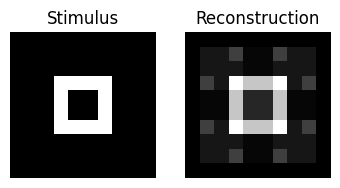

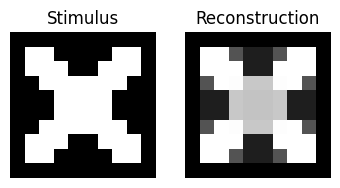

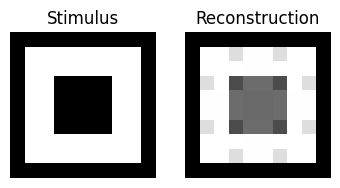

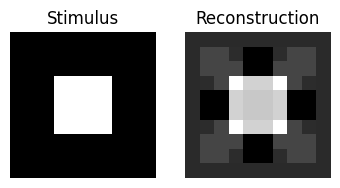

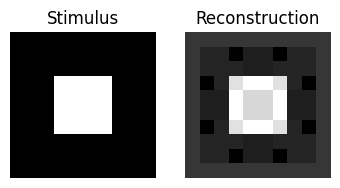

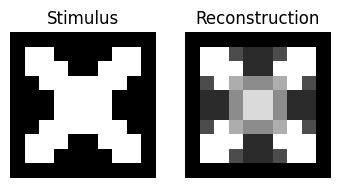

In [76]:
# Plotting 6 reconstructed images of geometric figures to compare with the ground truth
for i in range(6):
    j = 10 * i
    fig = plt.figure()
    sp1 = plt.subplot(131)
    sp1.axis('off')
    plt.title('Stimulus')
    sp2 = plt.subplot(132)
    sp2.axis('off')
    plt.title('Reconstruction')
    sp1.imshow(np.reshape(y_geo_test[j], (10, 10)), cmap=plt.cm.gray,
               interpolation='nearest'),
    sp2.imshow(np.reshape(y_geo_pred[j], (10, 10)), cmap=plt.cm.gray,
               interpolation='nearest'),

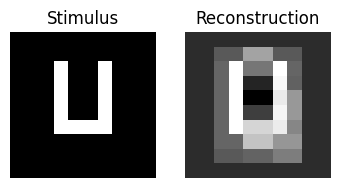

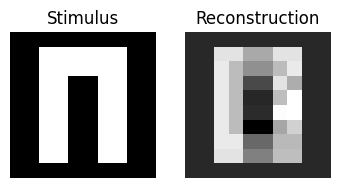

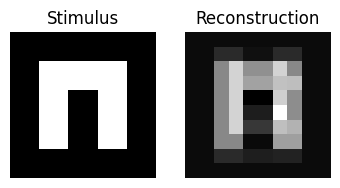

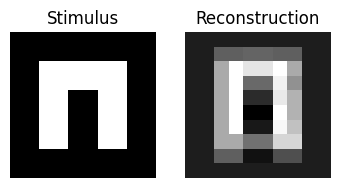

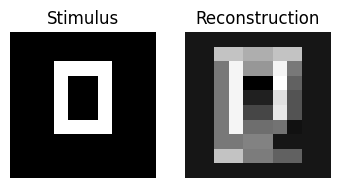

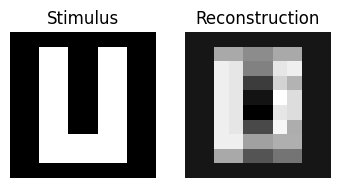

In [77]:
# Plotting 6 reconstructed images of letters to compare with the ground truth
for i in range(6):
    j = 10 * i
    fig = plt.figure()
    sp1 = plt.subplot(131)
    sp1.axis('off')
    plt.title('Stimulus')
    sp2 = plt.subplot(132)
    sp2.axis('off')
    plt.title('Reconstruction')
    sp1.imshow(np.reshape(y_let_test[j], (10, 10)), cmap=plt.cm.gray,
               interpolation='nearest'),
    sp2.imshow(np.reshape(y_let_pred[j], (10, 10)), cmap=plt.cm.gray,
               interpolation='nearest'),

Hence, we managed to reconstruct stimuli images, given the fmri data using the model. 

In [81]:
# In order to further analyse the recreated images, we can calculate the accuracy of the model

# 1. Geometric figures
shapes_acc=np.mean([accuracy_score(y_geo_test[:, i], y_geo_pred[:, i] > .5) for i in range(100)])
print("Accuracy of prediction of geometric figures: %f" %geo_acc)

# 2. Letters
letters_acc=np.mean([accuracy_score(y_let_test[:, i], y_let_pred[:, i] > .5) for i in range(100)])
print("Accuracy of prediction of letters: %f" %let_acc)

Accuracy of prediction of geometric figures: 0.988333
Accuracy of prediction of letters: 0.965000


From the results of the accuracies obtained above, we see that the accuracy for the geometric figures is higher than the same for letters. 